In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, resample
plt.style.use('ggplot')
%matplotlib widget

def load_data(dir, w, c, datetime):
    name = '%sS21s_w%d_%s_%s.npy' % (dir, w, c, datetime)
    darkname = '%s/S21_w%d_%s_%s_dark.npy' % (dir, w, c, datetime)
    freqsname = '%s/S21_w%d_%s_%s_freqs.npy' % (dir, w, c, datetime)
    # settings = '%s/S21_w%d_%s_%s_settings.txt' % (dir, w, c, datetime)
    s21s = np.load(name)
    s21dark = np.load(darkname)
    freqs = np.load(freqsname)
    return s21s, s21dark, freqs

def moving_average_filter(data, window_width):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_width:] = cumsum[window_width:] - cumsum[:-window_width]
    result = cumsum[window_width - 1:] / window_width
    result = np.concatenate((np.full(window_width - 1, result[0]), result))
    return result
            
def make_array():
    dir = 'S21s/19-10-23_w1_blue/'
    datetime = '12h16_19-10-2023'
    color = 'blue'
    w = 1
    freqsname = '%sS21_w%d_%s_%s_freqs.npy' % (dir, w, color, datetime)
    darkname = '%sS21_w%d_%s_%s_dark.npy' % (dir, w, color, datetime)
    freqs = np.load(freqsname)
    dark = np.load(darkname)
    data = np.zeros((45, 2, len(freqs)))
    for i in range(45):
        namex = '%sS21_x%dy0_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        namey = '%sS21_x0y%d_w%d_%s_%s.npy' % (dir, i+1, w, color, datetime)
        data[i, 0, :] = np.load(namex)
        data[i, 1, :] = np.load(namey)
    dataname = '%sS21s_w%d_%s_%s.npy' % (dir, w, color, datetime)
    np.save(dataname, data)

In [526]:
dir = 'S21s/19-10-23_w1_blue/'
s21s, dark, freqs = load_data(dir, 1, 'blue', '12h16_19-10-2023')
M_pxs = 20
N_pxs = 20
nr_scans = s21s.shape[0]
scan_stepsize = 75
px_size = 150
min_sep = px_size / 2
max_sep = px_size * np.sqrt(2)

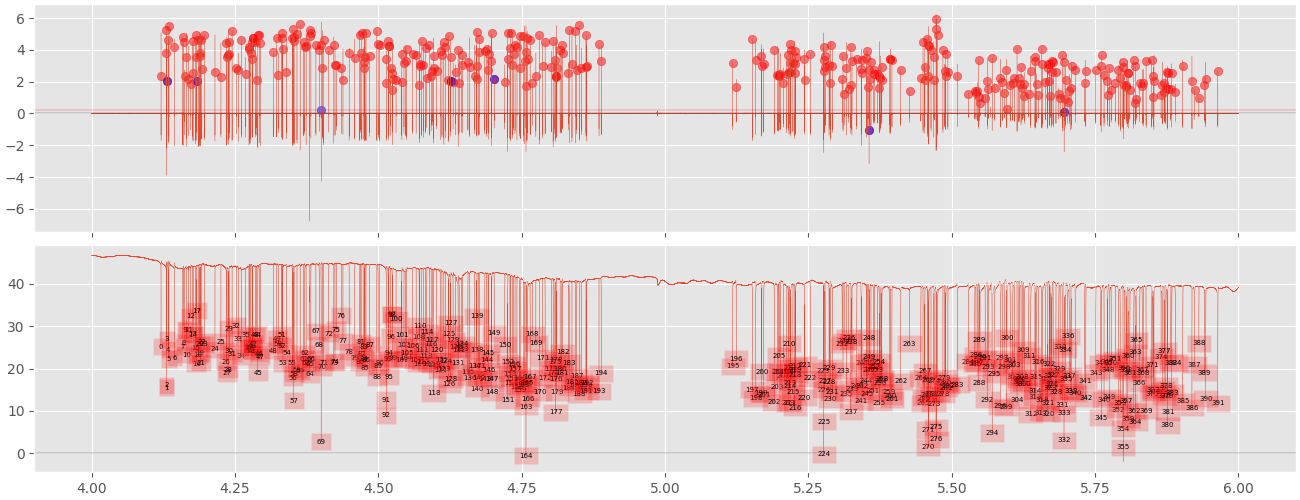

In [462]:
y = dark
width = 2
smoothed_y = moving_average_filter(y, width)
first_diff_y = np.diff(smoothed_y, 1)
smoothed_first_diff_y = moving_average_filter(first_diff_y, width)
sec_diff_y = np.diff(smoothed_first_diff_y, 1)
smoothed_sec_diff_y = moving_average_filter(sec_diff_y, width)

sel = 0.25
pks, props = find_peaks(smoothed_sec_diff_y, height=sel, prominence=sel)
real_pks = []
hs = []
for pk in pks:
    h = y[pk]  
    x = pk 
    new_x = x-1 
    new_h = y[new_x]
    while new_h < h:
        x = new_x
        h = new_h
        new_x -= 1
        new_h = y[new_x]
    real_pks.append(x)
    hs.append(h)
pks = np.array(real_pks)
# hs = np.array(hs)
hs = smoothed_sec_diff_y[real_pks]

stds = 2
pks_diff = pks[1:]-pks[:-1]
mean_pks_diff = np.mean(pks_diff)
std_mean_pks_diff = np.std(pks_diff)
close_pks = pks_diff < mean_pks_diff - stds*std_mean_pks_diff
hs_diff = hs[1:]-hs[:-1]
mean_hs_diff = np.mean(hs_diff)
std_mean_hs_diff = np.std(hs_diff)
low_hs = hs_diff < mean_hs_diff - stds*std_mean_hs_diff
sketchy_pks = pks[1:][low_hs + close_pks]

remove = [69, 295]
pks = np.delete(pks, remove)
hs = np.delete(pks, remove)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(13, 5), constrained_layout=True)
ax['a'].plot(freqs[1:-1], smoothed_sec_diff_y, lw=.2)
ax['a'].scatter(freqs[1:-1][pks], smoothed_sec_diff_y[pks], color='r', alpha=0.5)
ax['a'].scatter(freqs[1:-1][sketchy_pks], smoothed_sec_diff_y[sketchy_pks], color='b', alpha=0.5)
ax['a'].axhline(0, 0, 1, color='k', lw=.2)
ax['a'].axhline(sel, 0, 1, color='r', lw=.2)
for i, label in enumerate(range(len(pks))):
    ax['b'].text(freqs[pks[i]], y[pks[i]], str(label), ha='center', va='center', fontsize=5, bbox=dict(facecolor='red', alpha=0.2))
ax['b'].plot(freqs, y, lw=.2)
# ax['b'].scatter(freqs[pks], y[pks], color='r', alpha=0.5)
ax['b'].axhline(0, 0, 1, color='k', lw=.2)
plt.show()


In [463]:
nr_pks = len(pks)
dark_heights = dark[pks]
height_diffs = np.zeros((nr_scans, nr_scans, nr_pks))
for i in range(nr_scans):
    scanx = s21s[i, 0, :]
    scany = s21s[i, 1, :]
    scanx_heights = scanx[pks]
    scany_heights = scany[pks]
    height_diffx = dark_heights - scanx_heights
    height_diffy = dark_heights - scany_heights
    height_diffs[i, 0, :] = height_diffx
    height_diffs[i, 1, :] = height_diffy

40

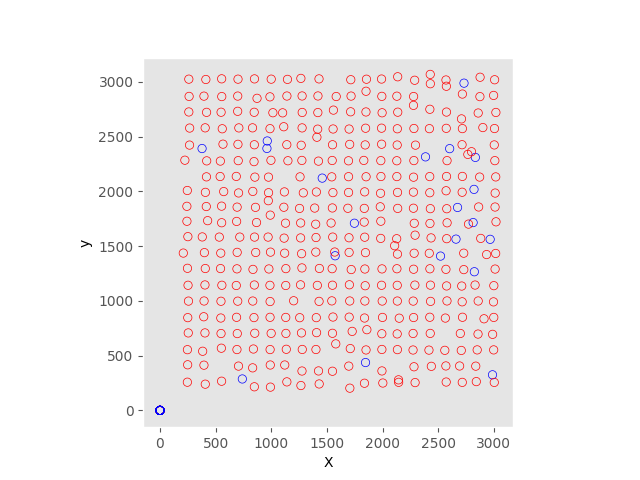

In [464]:
min = np.min(s21s)
max = np.max(s21s)
nr_pks = len(pks)
coords = np.zeros((nr_pks, 3)) 
coords[:, 0] = np.arange(nr_pks)+1

fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.grid(False)
height_diffs = resample(height_diffs, nr_scans*scan_stepsize, axis=0)
pos = np.arange(nr_scans*scan_stepsize)
dips = np.arange(nr_pks)
double_pks = np.zeros(nr_pks, dtype=bool)
for i in dips:
    scanx = height_diffs[:, 0, i]
    scany = height_diffs[:, 1, i]
    scanx = moving_average_filter(scanx, 50)
    scany = moving_average_filter(scany, 50)
    meanx = np.mean(scanx)
    stdx = np.std(scanx)
    meany = np.mean(scany)
    stdy = np.std(scany)
    scanx -= meanx - stdx
    scany -= meany - stdy

    scanxpks, props = find_peaks(-scanx, height=0, prominence = 2)
    scanypks, props = find_peaks(-scanx, height=0, prominence = 2)
    
    peakx = scanx < 0
    peaky = scany < 0

    pkx = np.amin(scanx)
    pky = np.amin(scany)
    
    if (len(scanxpks)==1) and (len(scanypks)==1):
        idxy = np.mean(pos[peaky])
        idxx = np.mean(pos[peakx])
        coords[i, 1:] = idxx, idxy
    else:   
        idxx = np.argmin(scanx)
        idxy = np.argmin(scany)
        double_pks[i] = True
        # coords[i, 1:] = idxx, idxy
        ax.scatter(idxx, idxy, facecolor='None', edgecolor='b')
        # fig, axes = plt.subplot_mosaic('ab', figsize=(10, 3))
        # axes['a'].plot(pos, scanx, lw=.5)
        # axes['a'].plot(pos, peakx, lw=.5)
        # axes['a'].set_title('%s, X' % (i))
        # axes['a'].scatter(idxx, pkx)
        # axes['b'].plot(pos, scany, lw=.5)
        # axes['b'].plot(pos, peaky, lw=.5)
        # axes['b'].set_title('%s, Y' % (i))
        # axes['b'].scatter(idxy, pky)
ax.scatter(coords[:, 1], coords[:, 2], facecolor='None', edgecolor='r')
ax.scatter(coords[double_pks, 1], coords[double_pks, 2], facecolor='None', edgecolor='b')
ax.set_xlabel('X')
ax.set_ylabel('y')
len(np.argwhere(coords==0))


In [465]:
dists = np.zeros((nr_pks, nr_pks))
for i in range(nr_pks):
        for j in range(nr_pks):
            dists[i, j] = np.linalg.norm(coords[i, 1:] - coords[j, 1:])
dists.shape

(392, 392)

In [496]:
too_close = np.zeros(nr_pks, dtype=bool)
too_close[np.hstack(np.where((dists < min_sep) & (dists != 0)))] = True
print('too close:', np.sum(too_close))

too close: 12


In [543]:
too_far = np.zeros(nr_pks, dtype=bool)
dists1 = dists[dists != 0]
print(dists1)
min_dists = np.argmin(dists1, axis=1)
# for i in range(nr_pks):
#     dist = dists[i, :]
#     min_dist = np.amin(dist, initial=0, where=(dist > 0))
#     if min_dist > (max_sep):
#         too_far[i] = True
min_dists
# print('too far:', np.sum(too_far))

[4261.03391209  738.50270819 4261.03391209 ...  189.05356384  323.4145946
  451.99695795]


AxisError: axis 1 is out of bounds for array of dimension 1

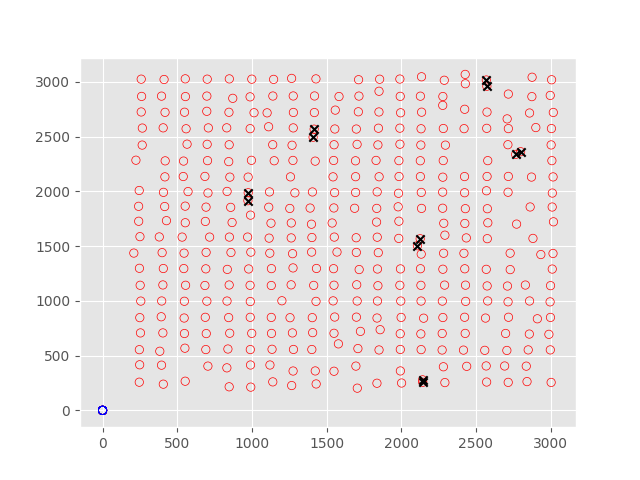

In [529]:
fig, ax = plt.subplots()
ax.scatter(coords[:, 1], coords[:, 2], facecolor='None', edgecolor='r')
ax.scatter(coords[too_close, 1], coords[too_close, 2], marker='x', facecolor='k')
ax.scatter(coords[too_far, 1], coords[too_far, 2], marker='x', facecolor='g')
ax.scatter(coords[double_pks, 1], coords[double_pks, 2], facecolor='None', edgecolor='b')


In [513]:
new_coords = np.delete(coords, too_close+double_pks, axis=0)
nr_sel_pks = len(new_coords)

x_min = np.amin(new_coords[:, 1])
y_min = np.amin(new_coords[:, 2])
x_max = np.amax(new_coords[:, 1])
y_max = np.amax(new_coords[:, 2])
new_coords[:, 1] -= x_min - px_size / 4
new_coords[:, 2] -= y_min - px_size / 4



In [525]:
def get_edges(array, axis): 
    dx = 25
    x = 25
    x_left = 0
    diff = 25
    x_edges = []
    min_sep = 50
    min_nr_kids = 1
    max_nr_kids = 20
    nr_kids_init = 0
    cum_nr_kids = 0
    while x < x_max:
        nr_kids = np.sum((array[:, axis] < x) & (array[:, axis] >= x_left))
        cum_nr_kids += nr_kids 
        if nr_kids > 0:
            if (diff >= min_sep) & (cum_nr_kids <= max_nr_kids) & (cum_nr_kids > max_nr_kids):
                x_edges.append(x - diff / 2)
                cum_nr_kids = nr_kids_init
            else:
                diff += dx
            diff = dx
        else:
            diff += dx
        x_left = x
        x = x_left + dx
    return np.array(x_edges)

x_edges = get_edges(new_coords, 1)
y_edges = get_edges(new_coords, 2)
print(x_edges)


[]


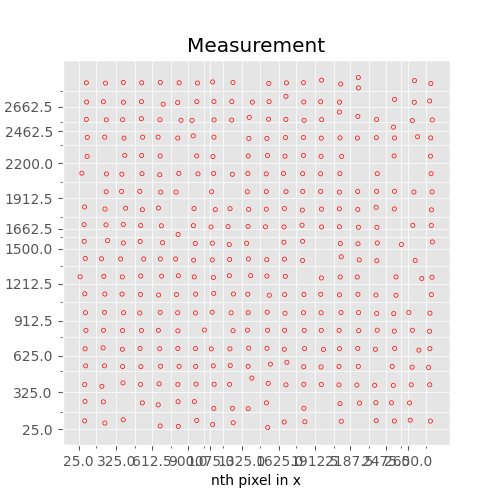

In [523]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(new_coords[:, 1], new_coords[:, 2], marker='.', facecolor='None', edgecolor='r')
xticks = x_edges
yticks = y_edges
ax.set_xticks(xticks[0::2])
ax.set_yticks(yticks[0::2])
# Labels for major ticks
ax.set_xticklabels(xticks[0::2])
ax.set_yticklabels(yticks[0::2])
# Minor ticks
ax.set_xticks(xticks+0.5, minor=True)
ax.set_yticks(yticks+0.5, minor=True)
# labels
ax.set_xlabel('nth pixel in x')
ax.set_ylabel('nth pixel in y')
ax.set_title("Measurement")
# grid
ax.grid(True, which='minor', color='w', linestyle='-', linewidth=0.5)
ax.grid(False, which='major')

Double:  94.0 ( 16 5 )


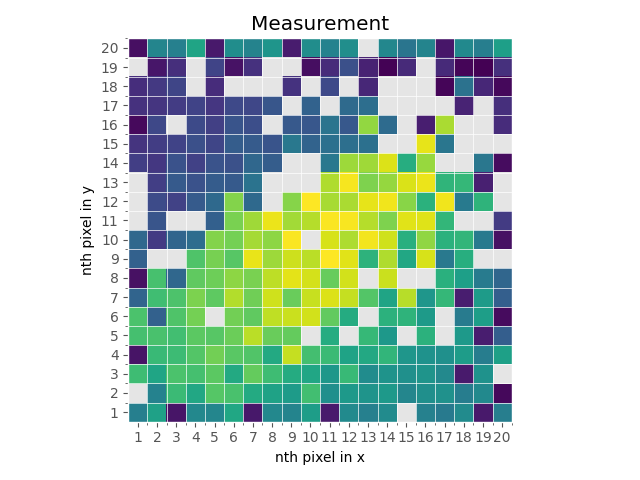

In [412]:
kids = np.empty((M_pxs, N_pxs))
kids[:] = np.nan

px = []
for i in range(nr_sel_pks):
    [x, y] = new_coords[i, 1:] // px_size
    x = int(x)
    y = int(y)
    if np.isnan(kids[x, y]):
        kids[x, y] = new_coords[i, 0]
    else:
        print('Double: ', new_coords[i, 0], '(',x, y,')')

fig, ax = plt.subplots()
ax.imshow(kids, origin='lower')
# Major ticks
ax.set_xticks(np.arange(0, M_pxs, 1));
ax.set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, M_pxs+1, 1));
ax.set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax.set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax.set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax.set_xlabel('nth pixel in x')
ax.set_ylabel('nth pixel in y')
ax.set_title("Measurement")
# grid
ax.grid(True, which='minor', color='w', linestyle='-', linewidth=0.5)
ax.grid(False, which='major')

# final
fig.tight_layout()

In [419]:
len(np.isnan(kids))

20

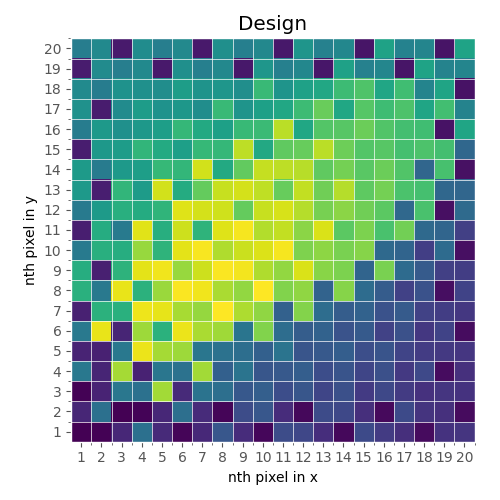

In [393]:
kid_id_board = np.load('./LT295_400pxl_design/KID_id_board_400.npy')


fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(kid_id_board, origin='lower')


# for i in range(nr_sel_pks):
#     text = ax.text(kids[i, 0], kids[i, 1], '%d' % new_coords[i, 0], ha="center", va="center", color="w", fontsize='x-small')    
# Major ticks
ax.set_xticks(np.arange(0, M_pxs, 1));
ax.set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, M_pxs+1, 1));
ax.set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax.set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax.set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax.set_xlabel('nth pixel in x')
ax.set_ylabel('nth pixel in y')
ax.set_title("Design")
# grid
ax.grid(True, which='minor', color='w', linestyle='-', linewidth=0.5)
ax.grid(False, which='major')


# final
fig.tight_layout()
